# MMOCR Tutorial

Welcome to MMOCR! This is the official colab tutorial for using MMOCR. In this tutorial, you will learn how to

- Install MMOCR from source
- Perform inference with
  - a pretrained text recognizer
  - a pretrained text detector
  - pretrained recognizer and detector
  - pretrained Key Information Extraction (KIE) model
- Evaluate a text detection model on an acadmic dataset
- Train a text recognizer with a toy dataset

Let's start!

## Install MMOCR from source

Installing MMOCR is straightforward. We recommend users to install MMOCR from source as any local code changes on MMOCR can take effect immediately, which is needed for research & developement purpose. Refer to [documentation](https://mmocr.readthedocs.io/en/dev-1.x/get_started/install.html) for more information.

### Install Dependencies using MIM

In [ ]:
# !pip install -U openmim
# !mim install mmengine
# !mim install 'mmcv>=2.0.0rc1'
# !mim install 'mmdet>=3.0.0rc0'

### Install MMOCR

In [ ]:
# !git clone https://github.com/open-mmlab/mmocr.git
# %cd mmocr
# !pip install -v -e .
# # "-v" increases pip's verbosity.
# # "-e" means installing the project in editable mode,
# # That is, any local modifications on the code will take effect immediately.

## Inference

MMOCR has made inference easy by providing a variety of `Inferencer`s. In this section, we will focus on the usage of `MMOCRInferencer`. However, if you want to learn more about other `Inferencer`s, you can refer to the [documentation](https://mmocr.readthedocs.io/en/dev-1.x/user_guides/inference.html) which provides detailed descriptions.

### Perform Inference with a Pretrained Text Recognizer 

We now demonstrate how to inference on a demo text recognition image with a pretrained text recognizer. SVTR text recognizer is used for this demo, whose checkpoint can be found in the [official documentation](https://mmocr.readthedocs.io/en/dev-1.x/textrecog_models.html#svtr). But you don't need to download it manually -- Our Inferencer script handles these cumbersome setup steps for you! 

Run the following command and you will get the inference result from return value as well as files, which will be  visualized in the end.

In [9]:
%%capture

import os
from mmocr.apis import MMOCRInferencer

infer = MMOCRInferencer(
    # rec='svtr-small'

    rec="ABINet",
    rec_weights='ckpt/mmocr_textrecog/cegdr/ABINet/1/extra_files/best_test_word_acc_epoch_1.pth',
)

DEMO_RECOG_IMG_DIR = 'data/HF_dataset/samples/ear-tags/recognition'

# Collect only the visualisation images
results = []
for fname in os.listdir(DEMO_RECOG_IMG_DIR):
    out = infer(os.path.join(DEMO_RECOG_IMG_DIR, fname), return_vis=True)
    vis_bgr = out['visualization'][0]      # ndarray, BGR
    vis_rgb = vis_bgr[..., ::-1]           # convert to RGB for matplotlib
    results.append(vis_rgb)

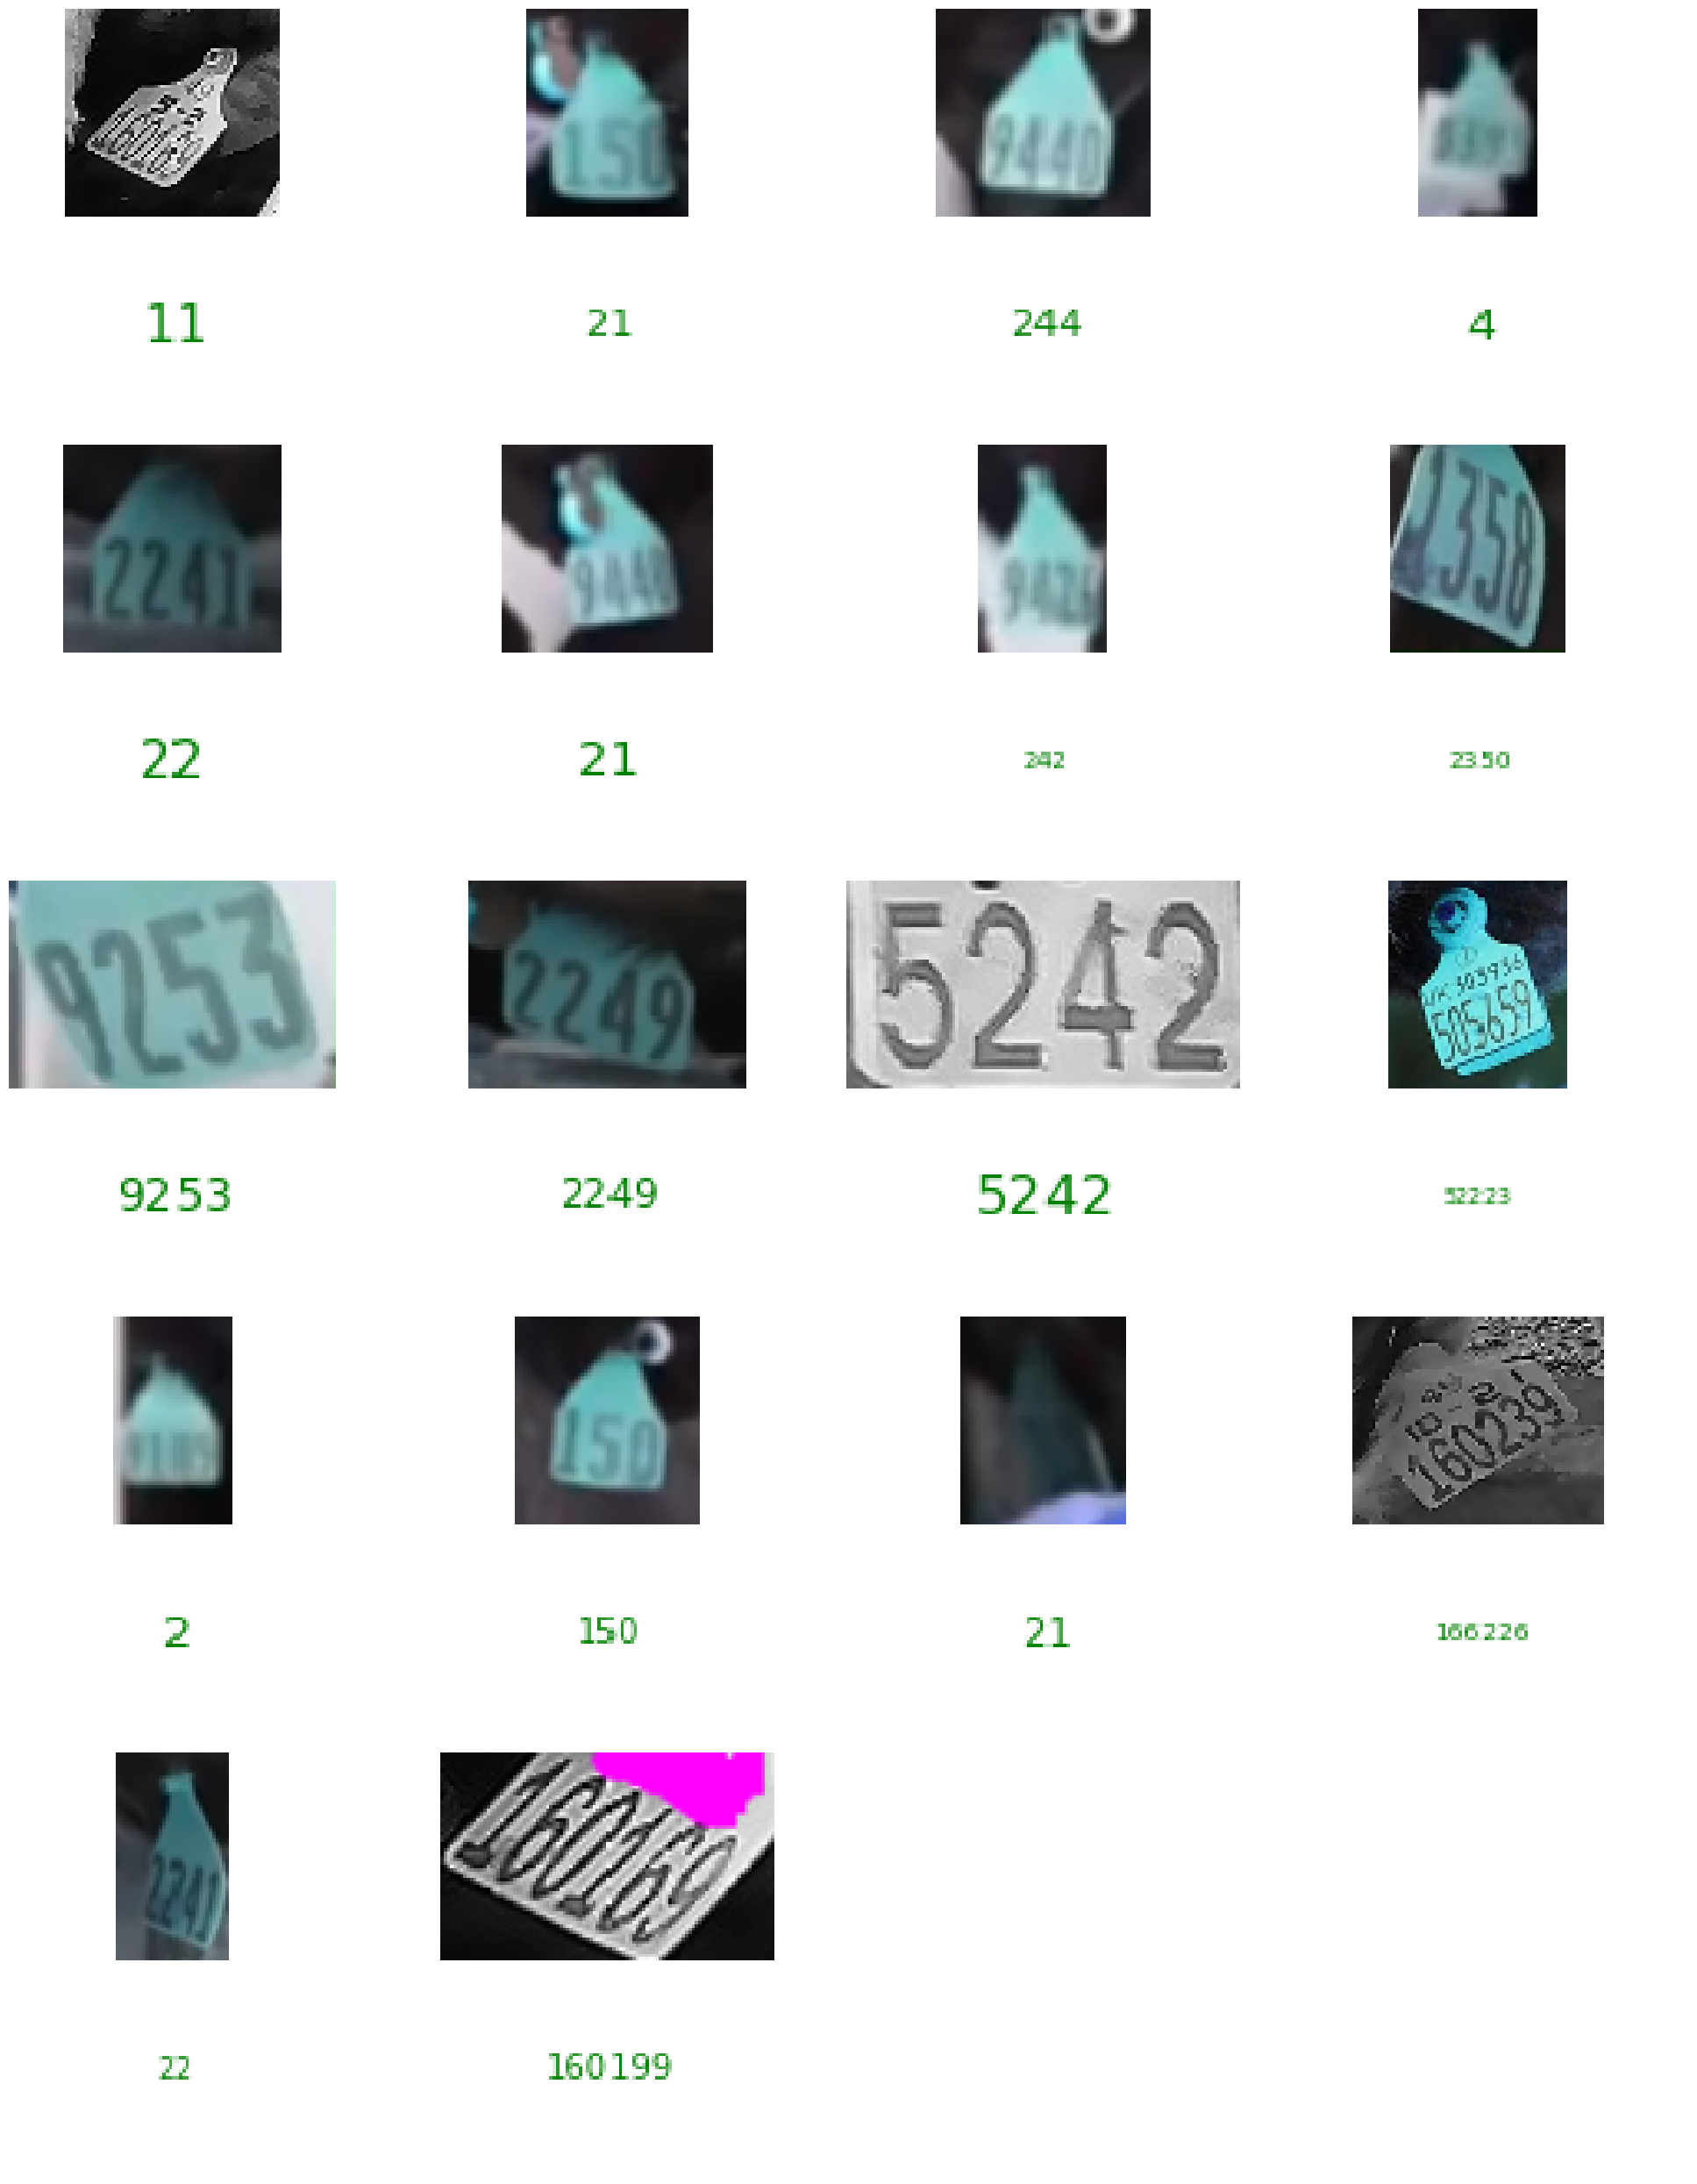

In [10]:
import math
import matplotlib.pyplot as plt

PLOT_COLS = 4

# Plot in grid
PLOT_ROWS = math.ceil(len(results) / PLOT_COLS)
fig, axes = plt.subplots(PLOT_ROWS, PLOT_COLS, figsize=(20, 5*PLOT_ROWS))
axes = axes.ravel()

for idx, img in enumerate(results):
    axes[idx].imshow(img)
    axes[idx].axis('off')

# Hide empty subplots
for idx in range(len(results), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Perform Inference with a Pretrained Text Detector 

Next, we perform inference with a pretrained DBNet++ text detector and visualize the bounding box results for the demo text detection image.

In [ ]:
%%capture

from mmocr.apis import MMOCRInferencer
from mmocr.apis import MMOCRInferencer
import os

infer = MMOCRInferencer(
    # det='dbnetpp',

    det="configs/textdet/dbnet_custom/dbnet_cegdr.py",
    det_weights='ckpt/mmocr_textdet/cegdr/DBNet/1/extra_files/best_test_hmean',
)

DEMO_DET_IMG_DIR = 'data/HF_dataset/samples/ear-tags/recognition'

# Get all images first
results = []
for test_img_path in os.listdir(DEMO_DET_IMG_DIR):
    result = infer(os.path.join(DEMO_DET_IMG_DIR, test_img_path), return_vis=True)
    results.append(result['visualization'][0])

07/31 11:09:16 - mmengine - INFO - Using env variable `MLFLOW_TRACKING_URI` with value of http://127.0.0.1:5000 to replace item in config.
07/31 11:09:16 - mmengine - INFO - Using env variable `MLFLOW_TRACKING_URI` with value of http://127.0.0.1:5000 to replace item in config.
07/31 11:09:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
07/31 11:09:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
07/31 11:09:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
07/31 11:09:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
07/31 11:09:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
07/31 11:09:16 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
07/31 11:09:16 - mmengine - INFO - ModulatedDeformConvPack backbone.

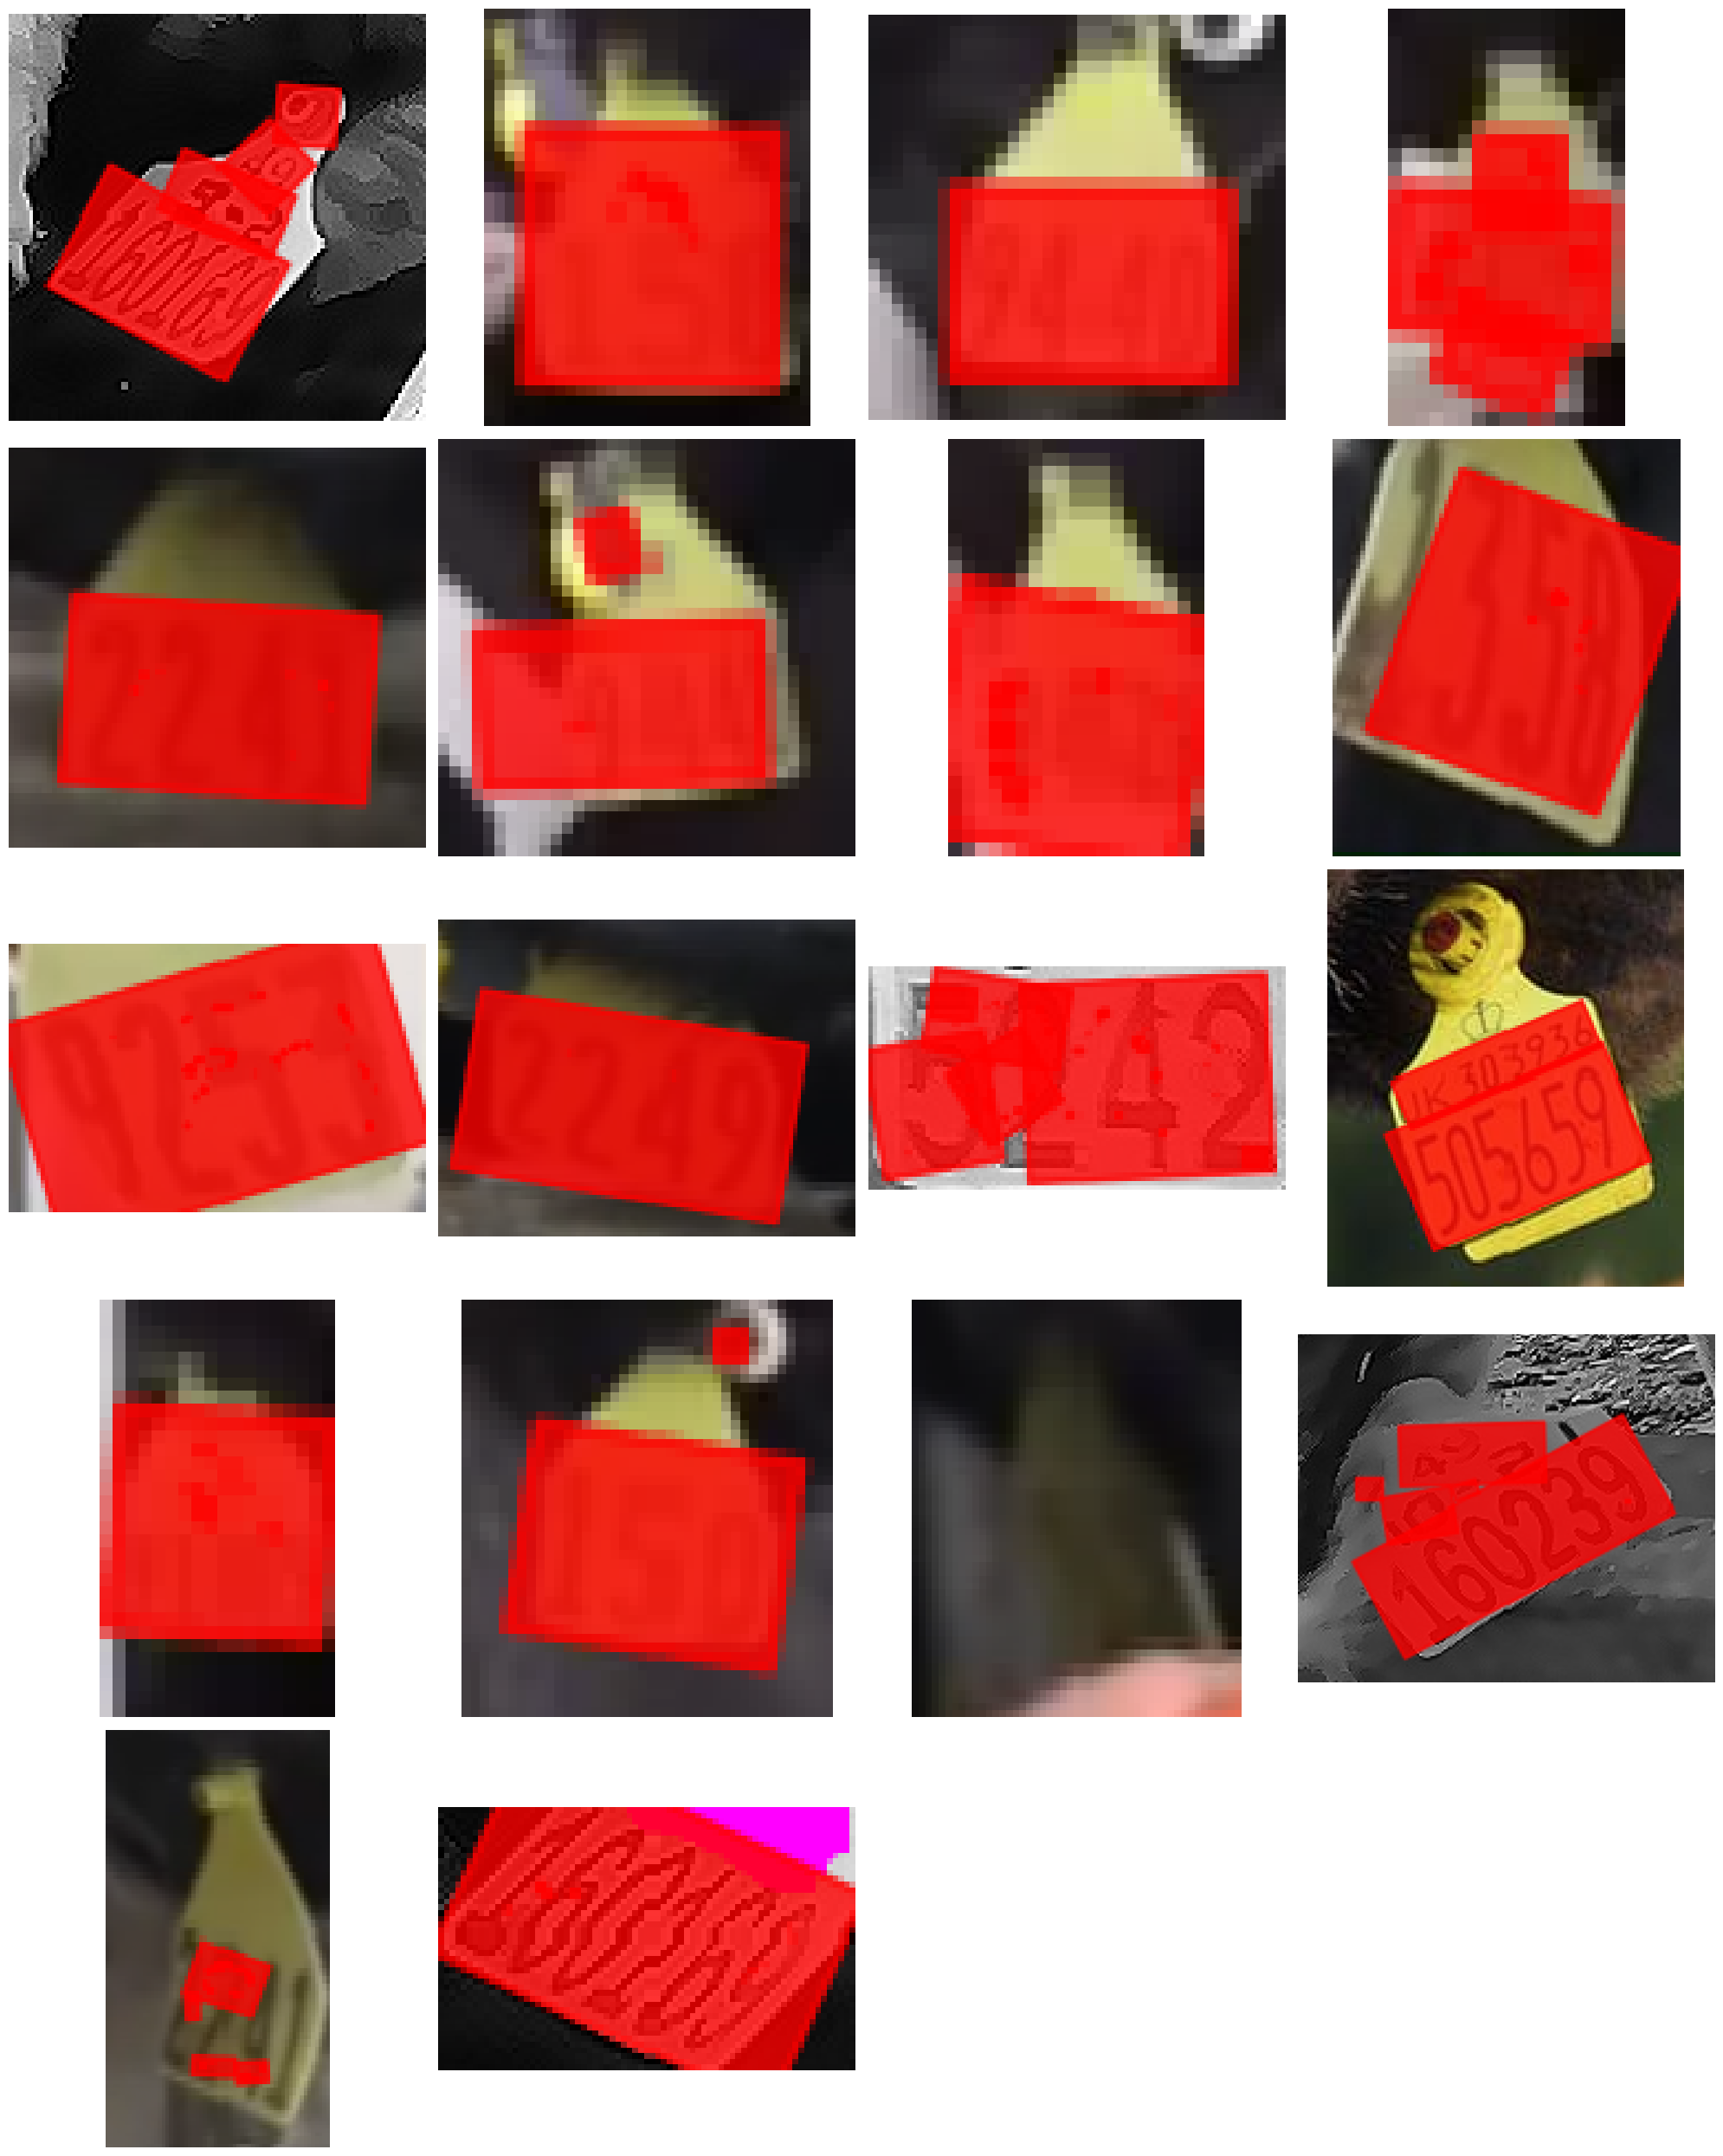

In [ ]:
import math
import matplotlib.pyplot as plt

PLOT_COLS = 4

# Plot in grid
PLOT_ROWS = math.ceil(len(results) / PLOT_COLS)
fig, axes = plt.subplots(PLOT_ROWS, PLOT_COLS, figsize=(20, 5*PLOT_ROWS))
axes = axes.ravel()

for idx, img in enumerate(results):
    axes[idx].imshow(img)
    axes[idx].axis('off')

# Hide empty subplots
for idx in range(len(results), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Perform end-to-end OCR with pretrained recognizer and detector

We can  any text detector and recognizer into a pipeline that forms a standard OCR pipeline. Now we build our own OCR pipeline with DBNet++ and SVTR and apply it to `demo/demo_text_ocr.jpg`.

In [2]:
import os
from mmocr.apis import MMOCRInferencer

infer = MMOCRInferencer(
    # det='dbnetpp',
    # rec='svtr-small',
    
    rec="ABINet",
    rec_weights='ckpt/mmocr_textrecog/cegdr/ABINet/1/extra_files/best_test_word_acc_epoch_1.pth',

    det="configs/textdet/dbnet_custom/dbnet_cegdr.py",
    det_weights='ckpt/mmocr_textdet/cegdr/DBNet/1/extra_files/best_test_hmean',
)

DEMO_E2EOCR_IMG_DIR = 'data/HF_dataset/samples/ear-tags/recognition'

07/31 12:48:31 - mmengine - INFO - Using env variable `MLFLOW_TRACKING_URI` with value of http://127.0.0.1:5000 to replace item in config.
07/31 12:48:31 - mmengine - INFO - Using env variable `MLFLOW_TRACKING_URI` with value of http://127.0.0.1:5000 to replace item in config.


/home/bonting/micromamba/envs/bonting-id/lib/python3.11/site-packages/mmengine/utils/package_utils.py:17: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/bonting/micromamba/envs/bonting-id/lib/python3.11/importlib/__init__.py:169: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  _bootstrap._exec(spec, module)


Loads checkpoint by local backend from path: ckpt/mmocr_textdet/cegdr/DBNet/1/extra_files/best_test_hmean
07/31 12:48:32 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
07/31 12:48:32 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
07/31 12:48:32 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
07/31 12:48:32 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
07/31 12:48:32 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
07/31 12:48:32 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
07/31 12:48:32 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
07/31 12:48:32 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
07/31 12:48:32 - mmeng

/home/bonting/micromamba/envs/bonting-id/lib/python3.11/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
/home/bonting/micromamba/envs/bonting-id/lib/python3.11/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.MLflowVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
/home/bonting/micromamba/envs/bonting-id/lib/python3.11/site-packages/mmocr/models/textrecog/module_losses/ce_module_loss.py:101: UserWarning: padding does not exist in the dictionary
  warnings.warn(
/home/bonting/micromamba/envs/bonting-id/lib/python3.11/site-packages/mmocr/models/textrecog/postprocessors/base.py:60: UserWarning: padding does not exist in the dictionary
  warnings.warn(


In [9]:
# %%capture

from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import os
import numpy as np

# N_IMGS = 2
N_IMGS = None

# Collect end-to-end OCR results with visualizations
results = []
predictions_arrays = []

for test_img_path in tqdm(os.listdir(DEMO_E2EOCR_IMG_DIR)[:N_IMGS]):
    result = infer(os.path.join(DEMO_E2EOCR_IMG_DIR, test_img_path), return_vis=True)
    
    # Extract visualization (BGR format, convert to RGB)
    vis_bgr = result['visualization'][0]
    vis_rgb = vis_bgr[..., ::-1]  # Convert BGR to RGB for matplotlib
    results.append(vis_rgb)
    
    # Extract recognized text with confidence scores
    text_confidence_pairs = []
    
    for pred in result['predictions']:
        if 'rec_texts' in pred and 'rec_scores' in pred:
            texts = pred['rec_texts']
            scores = pred['rec_scores']
            
            # Pair each text with its confidence score
            for text, score in zip(texts, scores):
                text_confidence_pairs.append((text, score))
    
    # Sort by confidence (highest first) and limit to first 4
    text_confidence_pairs.sort(key=lambda x: x[1], reverse=True)
    predictions_arrays.append(text_confidence_pairs[:4])

  0%|          | 0/18 [00:00<?, ?it/s]

Output()

/home/bonting/micromamba/envs/bonting-id/lib/python3.11/site-packages/mmcv/cnn/bricks/transformer.py:819: 
UserWarning: Use same attn_mask in all attentions in BaseTransformerLayer 
  warnings.warn(f'Use same attn_mask in all attentions in '

/home/bonting/micromamba/envs/bonting-id/lib/python3.11/site-packages/torch/nn/functional.py:5076: UserWarning: 
Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(

  6%|▌         | 1/18 [00:00<00:02,  8.01it/s]

Output()

 11%|█         | 2/18 [00:00<00:05,  3.02it/s]

Output()

Output()

 22%|██▏       | 4/18 [00:01<00:07,  1.95it/s]

Output()

 28%|██▊       | 5/18 [00:02<00:05,  2.41it/s]

Output()

 33%|███▎      | 6/18 [00:02<00:04,  2.83it/s]

Output()

/home/bonting/micromamba/envs/bonting-id/lib/python3.11/site-packages/mmengine/visualization/visualizer.py:831: 
UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(

 39%|███▉      | 7/18 [00:03<00:05,  1.96it/s]

Output()

 44%|████▍     | 8/18 [00:03<00:04,  2.18it/s]

Output()

 50%|█████     | 9/18 [00:04<00:05,  1.61it/s]

Output()

 56%|█████▌    | 10/18 [00:04<00:03,  2.11it/s]

Output()

 61%|██████    | 11/18 [00:05<00:04,  1.56it/s]

Output()

 67%|██████▋   | 12/18 [00:05<00:02,  2.08it/s]

Output()

 72%|███████▏  | 13/18 [00:06<00:02,  2.07it/s]

Output()

 78%|███████▊  | 14/18 [00:06<00:01,  2.67it/s]

Output()

Output()

 89%|████████▉ | 16/18 [00:06<00:00,  3.96it/s]

Output()

 94%|█████████▍| 17/18 [00:07<00:00,  2.59it/s]

Output()

100%|██████████| 18/18 [00:07<00:00,  2.36it/s]


/tmp/ipykernel_478013/1182509051.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


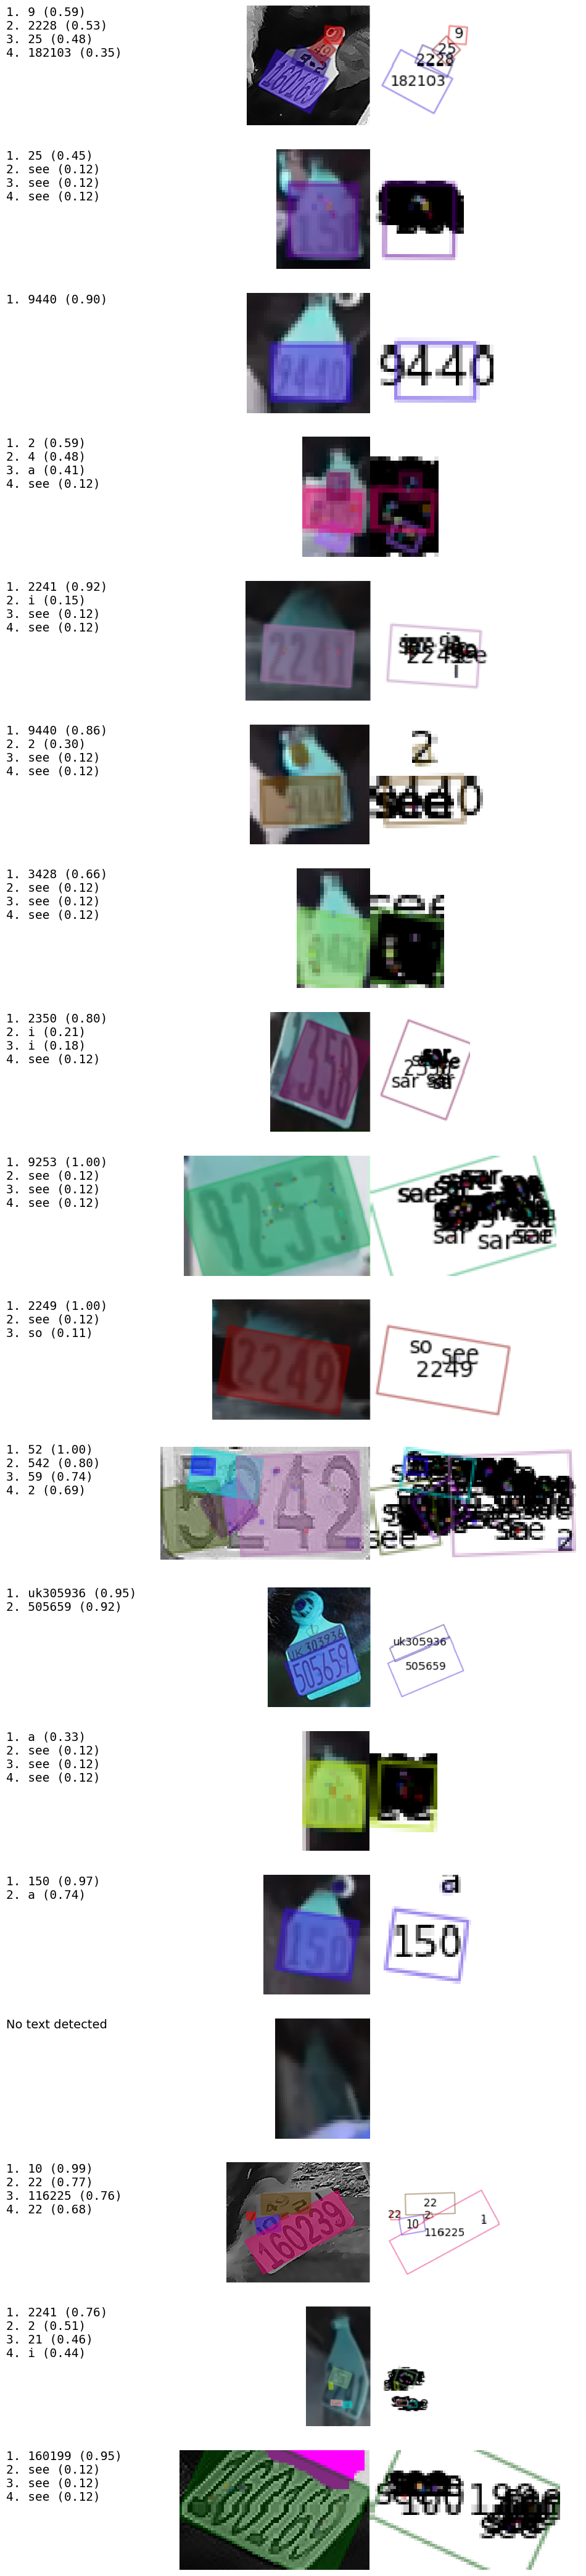

: 

In [ ]:
# Visualize end-to-end OCR results

PLOT_ROWS = len(results)
fig, axes = plt.subplots(
    PLOT_ROWS, 2,
    figsize=(12, 3 * PLOT_ROWS),
    gridspec_kw={'width_ratios': [1, 3], 'wspace': 0.05}
)
if PLOT_ROWS == 1:
    axes = axes.reshape(1, -1)

for idx, (img, pred_array) in enumerate(zip(results, predictions_arrays)):
    text_ax, img_ax = axes[idx]

    # --- image ---
    img_ax.imshow(img)
    img_ax.axis('off')

    # --- recognized texts ---
    text_ax.axis('off')
    if pred_array:
        lines = [f'{i+1}. {txt} ({score:.2f})'
                 for i, (txt, score) in enumerate(pred_array)]
        text_ax.text(
            0.0, 1.0, '\n'.join(lines),
            fontsize=14,
            va='top', ha='left',
            fontfamily='monospace')
    else:
        text_ax.text(0.0, 1.0, 'No text detected',
                     fontsize=14, va='top')

plt.tight_layout()
plt.show()

# Caveats

In [ ]:
# Init config existing in mmocr

# from mmengine.hub import get_config

# cfg = get_config('mmocr::textrecog/sar/sar_resnet31_parallel-decoder_5e_toy.py')
# cfg